In [1]:
import cv2
import numpy as np
import os
import pytesseract
from matplotlib import pyplot as plt
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [2]:
def preprocess(img, kernel_size=(1, 5)):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_all = np.array([25, 50, 70])
    upper_all = np.array([100, 255, 255])
    mask_all = cv2.inRange(hsv, lower_all, upper_all)
    all_res = cv2.bitwise_and(img, img, mask=mask_all)
    green_gau = cv2.GaussianBlur(all_res, (13, 13), 0)
    green_gau = cv2.cvtColor(green_gau, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(3, 3))
    img = clahe.apply(green_gau)
    dst = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, kernel_size)
    # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    dst = cv2.morphologyEx(dst, cv2.MORPH_CLOSE, kernel)
    dst = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel)
    nkernel = np.ones((7, 7), np.uint8)
    dst = cv2.morphologyEx(dst, cv2.MORPH_CLOSE, nkernel)
    dst = cv2.medianBlur(dst, 3)
    dst = cv2.filter2D(dst, -1, sharpening)
    dst = 255 - dst
    return dst

In [3]:
sharpening = np.array([
    [-1, -1, -1, -1, -1],
    [-1, 2, 2, 2, -1],
    [-1, 2, 9, 2, -1],
    [-1, 2, 2, 2, -1],
    [-1, -1, -1, -1, -1]
]) / 9.0

In [4]:
path = 'cur_imgs'
img_list = os.listdir(path)

In [5]:
img_list

['20210719-79901_20210721_124302.jpg',
 '20210719-79901_20210721_145106.jpg',
 '20210719-79901_20210721_145134.jpg',
 '20210719-79901_20210721_145450.jpg',
 '20210719-79901_20210721_145454.jpg',
 '20210719-79901_20210721_150222.jpg']

In [6]:
def ocr_reshape(ress):
    if len(ress) > 0:
            if ress[0] == '0':
                if len(ress) == 4:
                    res = round(float(ress) / 1000.0, 2)
                    # print(i, ' : ', round(float(text_ocr)//1000.0, 2))
                elif len(ress) == 3:
                    res = float(ress) / 100.0
                    # print(i, ' : ', float(text_ocr) / 100.0)
                elif len(ress) == 2:
                    res = float(ress) / 10.0
                else:
                    res = 999.999
            else:

                if len(ress) == 4:
                    res = round(float(ress) / 10000.0, 2)
                elif len(ress) == 3:
                    res = float(ress) / 1000.0
                elif len(ress) == 2:
                    res = float(ress) / 100.0
                elif len(ress) == 1:
                    res = float(ress) / 10.0
    else:
        res = 999.999
    return res

현재 사용중인 PreProcessing에 OCR 적용

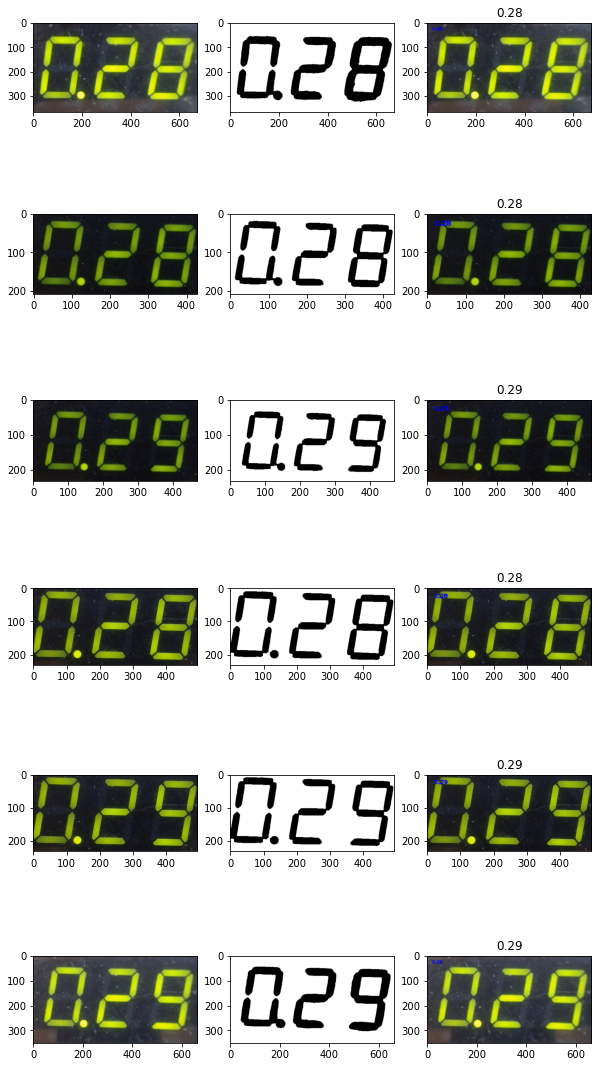

In [11]:
plt.figure(figsize=(10,20))
columns = 3
for i, image in enumerate(img_list):
    ori_img = cv2.imread(os.path.join(path, image))
    img = preprocess(ori_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    ocr_res = pytesseract.image_to_string(img, config='--psm 13 --oem 3 -c tessedit_char_whitelist=0123456789')[
                   :-1].strip()
    ocr_res = ocr_reshape(ocr_res)
    ocr_img = ori_img.copy()
    cv2.putText(ocr_img, str(ocr_res), (20,30), 1, 1.2, (0,0,255), 2)
    plt.subplot(len(img_list), 3, columns * i + 1)
    plt.imshow(ori_img)
    plt.subplot(len(img_list), 3, columns * i + 2)
    plt.imshow(img)
    plt.subplot(len(img_list), 3, columns * i + 3)
    plt.imshow(ocr_img)
    plt.title(ocr_res)
plt.show()

In [8]:
def h_l_passfilter(img):
    x = cv2.Sobel(img, cv2.CV_16S, 1, 0)
    y = cv2.Sobel(img, cv2.CV_16S, 0, 1)
    absx = cv2.convertScaleAbs(x)
    absy = cv2.convertScaleAbs(y)
    dist = cv2.addWeighted(absx, 0.5, absy, 0.5, 0)
    return dist

High Pass, Low Pass Filter 사용하여 OCR 적용

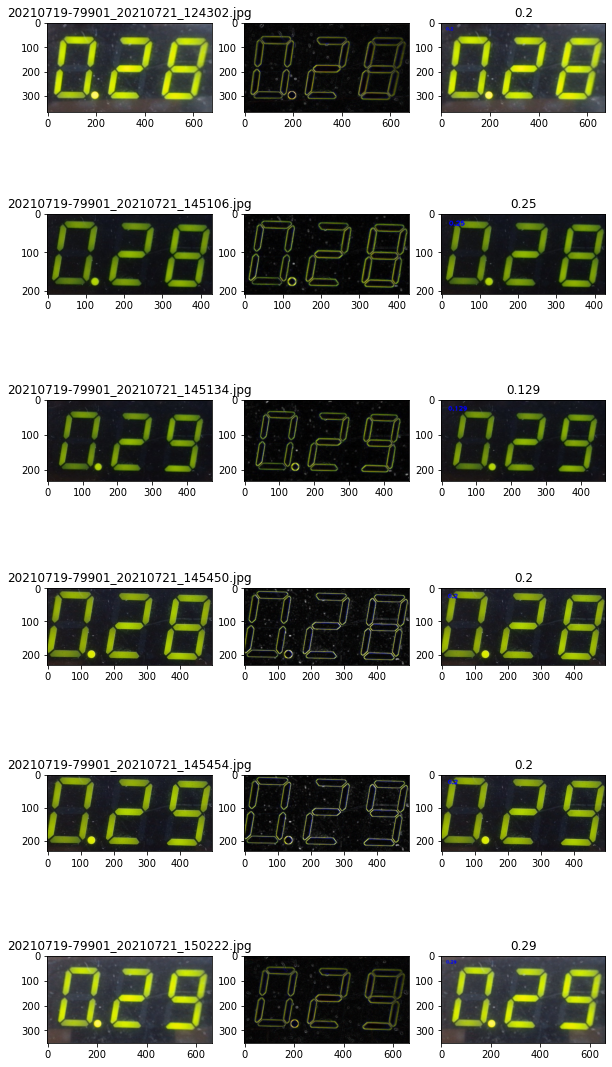

In [9]:
plt.figure(figsize=(10,20))
columns = 3
for i, image in enumerate(img_list):
    ori_img = cv2.imread(os.path.join(path, image))
    img = h_l_passfilter(ori_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    ocr_res = pytesseract.image_to_string(img, config='--psm 13 --oem 3 -c tessedit_char_whitelist=0123456789')[
                   :-1].strip()
    ocr_res = ocr_reshape(ocr_res)
    ocr_img = ori_img.copy()
    cv2.putText(ocr_img, str(ocr_res), (20,30), 1, 1.2, (0,0,255), 2)
    plt.subplot(len(img_list), 3, columns * i + 1)
    plt.imshow(ori_img)
    plt.title(image)
    plt.subplot(len(img_list), 3, columns * i + 2)
    plt.imshow(img)
    plt.subplot(len(img_list), 3, columns * i + 3)
    plt.imshow(ocr_img)
    plt.title(ocr_res)
plt.show()

기존 이미지에 OCR 적용

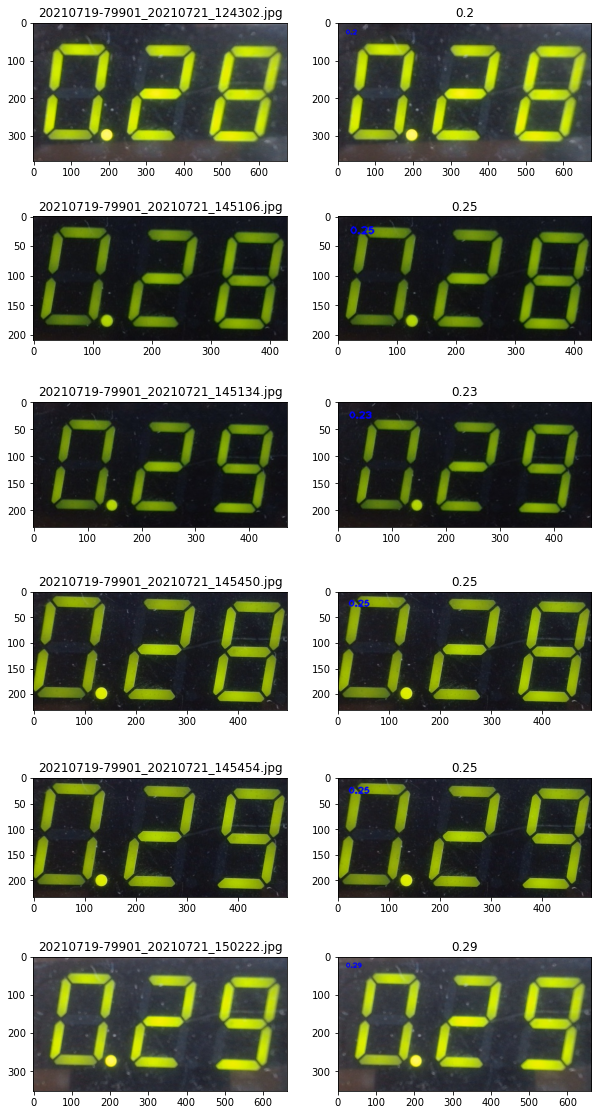

In [10]:
plt.figure(figsize=(10,20))
columns = 2
for i, image in enumerate(img_list):
    ori_img = cv2.imread(os.path.join(path, image))
    img = h_l_passfilter(ori_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    ocr_res = pytesseract.image_to_string(ori_img, config='--psm 13 --oem 3 -c tessedit_char_whitelist=0123456789')[
                   :-1].strip()
    ocr_res = ocr_reshape(ocr_res)
    ocr_img = ori_img.copy()
    cv2.putText(ocr_img, str(ocr_res), (20,30), 1, 1.2, (0,0,255), 2)
    plt.subplot(len(img_list), 2, columns * i + 1)
    plt.imshow(ori_img)
    plt.title(image)
    plt.subplot(len(img_list), 2, columns * i + 2)
    plt.imshow(ocr_img)
    plt.title(ocr_res)
plt.show()